In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import dotenv
import os
import utils

# Import specific client handling for Dune analytics
from dune_client.types import QueryParameter
from dune_client.client import DuneClient
from dune_client.query import QueryBase
from flipside import Flipside

In [2]:
# Load .env environment variables
dotenv.load_dotenv()

# Setup Dune Analytics API client
API_KEY = os.getenv('API_KEY')
FLIPSIDE_API_KEY = os.getenv('FLIPSIDE_API_KEY')
dune = DuneClient(api_key=API_KEY, base_url="https://api.dune.com", request_timeout=300)


In [3]:
# Download historical price data for ETH and ENA from Yahoo Finance
eth_hourly = yf.download('ETH-USD', start='2024-04-02', end='2024-07-07', interval='1h')['Close']
ena_hourly = yf.download('ENA-USD', start='2024-04-02', end='2024-07-07', interval='1h')['Close']

# Trim the dataset to make make ETH and ENA data equally large

start_time = pd.Timestamp('2024-04-02 10:00:00', tz='UTC')

# Trim the data to start from the specified timezone-aware time
eth_hourly = eth_hourly[eth_hourly.index >= start_time]
ena_hourly = ena_hourly[ena_hourly.index >= start_time]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Calculate hourly returns for ETH and ENA
eth_hourly_returns = eth_hourly.pct_change()
ena_hourly_returns = ena_hourly.pct_change()


In [5]:
"""
query = QueryBase(
    query_id=3584284 # https://dune.com/queries/3568055 -> DEX Pair Stats
)

query_result = dune.get_latest_result_dataframe(
    query=query
    , filters="Calimed > 1000"
    , sort_by=["Calimed desc"]
) 

query_result.drop(columns=['Debank', 'Arkham', 'ENS', 'Address'], inplace=True)
query_result.rename(columns={'Calimed': 'Claimed'}, inplace=True)

# to csv
query_result.to_csv('ena_claimed_data.csv', index=False)
"""

'\nquery = QueryBase(\n    query_id=3584284 # https://dune.com/queries/3568055 -> DEX Pair Stats\n)\n\nquery_result = dune.get_latest_result_dataframe(\n    query=query\n    , filters="Calimed > 1000"\n    , sort_by=["Calimed desc"]\n) \n\nquery_result.drop(columns=[\'Debank\', \'Arkham\', \'ENS\', \'Address\'], inplace=True)\nquery_result.rename(columns={\'Calimed\': \'Claimed\'}, inplace=True)\n\n# to csv\nquery_result.to_csv(\'ena_claimed_data.csv\', index=False)\n'

In [6]:
"""
# Fetch and process airdrop claim data from Dune Analytics
query_id = 3583363  # This is a hypothetical ID for the query
query_result_df = dune.get_latest_result_dataframe(query=query_id)
query_result_df['Datetime'] = pd.to_datetime(query_result_df['block_hour'])
query_result_df['Date'] = query_result_df['Datetime'].dt.date
daily_claimed_tokens = query_result_df.groupby('Date')['claimed'].sum().reset_index()
"""


"\n# Fetch and process airdrop claim data from Dune Analytics\nquery_id = 3583363  # This is a hypothetical ID for the query\nquery_result_df = dune.get_latest_result_dataframe(query=query_id)\nquery_result_df['Datetime'] = pd.to_datetime(query_result_df['block_hour'])\nquery_result_df['Date'] = query_result_df['Datetime'].dt.date\ndaily_claimed_tokens = query_result_df.groupby('Date')['claimed'].sum().reset_index()\n"

In [7]:
# Load Pendle ENA yield hourly data
ena_hourly_yield = pd.read_csv('ENA_fixed_yield_hourly.csv')

# Convert 'time' to datetime with timezone, and then convert to UTC
ena_hourly_yield['time'] = pd.to_datetime(ena_hourly_yield['time'], format='%a %b %d %Y %H:%M:%S GMT%z (Eastern European Summer Time)')
ena_hourly_yield['time'] = ena_hourly_yield['time'].dt.tz_convert('UTC')

# Rename columns
ena_hourly_yield.rename(columns={'time': 'Datetime', 'impliedApy': 'Implied_APY'}, inplace=True)


In [8]:

# Initialize `Flipside` with your API Key and API Url
flipside = Flipside(FLIPSIDE_API_KEY, "https://api-v2.flipsidecrypto.xyz")
sql = """
with

A as(       select 'ethereum' as chain, origin_from_address as user, from_address as contract, to_address   as pool,     amount as amount, contract_address, block_timestamp from ethereum.core.ez_token_transfers 
union all   select 'ethereum' as chain, origin_to_address   as user, to_address   as contract, from_address as pool, 0 - amount as amount, contract_address, block_timestamp from ethereum.core.ez_token_transfers 
),

-- stake
B as(
select    date_trunc('day',block_timestamp) as time, 'Manual stake' as action, sum(amount) as stake
from      A 
where     contract_address = '0x57e114b691db790c35207b2e685d4a43181e6061'
and       pool in ('0x8707f238936c12c309bfc2b9959c35828acfc512')
group by  1,2),

-- fill gap
T1 as (select distinct time  from B),
T2 as (select distinct action from B),
T as( select time, action from T1, T2 group by 1,2),

C as(
select    a.time, a.action, case when stake is null then 0 else stake end as stake
from      T as a 
left join B as b on a.time = b.time and a.action = b.action),

D as(
select    time, action, 
          stake,
          sum(stake) over(partition by action order by time) as stake_action,
          sum(stake) over(order by time) as stake_total
from      C),

P as(     
select    date(hour) as date, token_address, avg(price) as price 
from       ethereum.price.ez_prices_hourly
where     token_address  = '0x57e114b691db790c35207b2e685d4a43181e6061'
group by  1,2 ),

-- total supply
AC as(     select from_address as contract,     amount as amount, contract_address, block_timestamp from ethereum.core.ez_token_transfers 
union all  select to_address   as contract, 0 - amount as amount, contract_address, block_timestamp from ethereum.core.ez_token_transfers 
),

BC as(
select    sum(amount) as amount
from      AC
where     contract_address = '0x57e114b691db790c35207b2e685d4a43181e6061'
and       contract in ('0x0000000000000000000000000000000000000000')
),

E as(
select    'ENA' as token, 'Staking TVL' as pool,
           time, price,
           stake,        price*stake        as tvl_daily,
           stake_total,  price*stake_total  as tvl_total
from       D  as a 
left join  P  as b on date(a.time) = b.date )



select    *,
          case when time = (select max(time) from E) then stake_total else null end as pie,
          case when time = (select max(time) from E) then round(stake_total/(select amount from BC)*100,4) end as supply_rate
from      E
order by  time desc
"""

# Run the query against Flipside's query engine and await the results
query_result_set = flipside.query(sql)

# Function to auto-paginate query results from flipside
def auto_paginate_result(query_result_set, page_size=10000):
    """
    This function auto-paginates a query result to get all the data. It assumes 10,000 rows per page.
    In case of an error, reduce the page size. Uses numpy.
    """
    num_rows = query_result_set.page.totalRows
    page_count = np.ceil(num_rows / page_size).astype(int)
    all_rows = []
    current_page = 1
    while current_page <= page_count:
        results = flipside.get_query_results(
            query_result_set.query_id,
            page_number=current_page,
            page_size=page_size
        )

        if results.records:
            all_rows.extend(results.records)  # Use extend() to add list elements

        current_page += 1  # Increment the current page number

    return all_rows  # Return all_rows in JSON format

ena_stake_data_json = auto_paginate_result(query_result_set)
# Create a new json file with the results

ena_stake_data = pd.DataFrame(ena_stake_data_json)

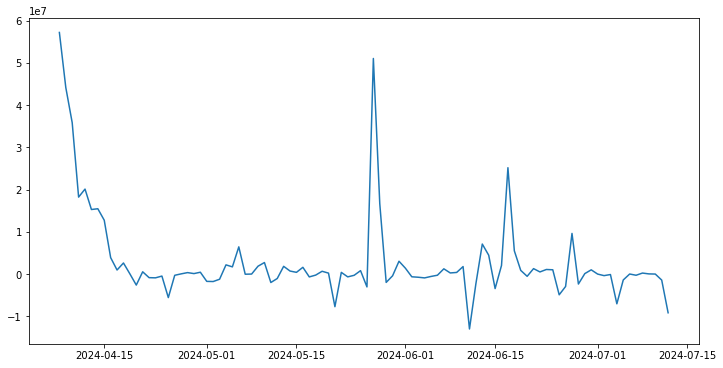

In [10]:
ena_stake_data_daily = ena_stake_data[['time', 'stake', 'stake_total']].rename(columns={'time': 'Datetime', 'stake': 'Stake', 'stake_total': 'Total_Stake'})

# Turn the datetime column into a datetime object
ena_stake_data_daily['Datetime'] = pd.to_datetime(ena_stake_data_daily['Datetime'])

## Try to create an hourly df

In [ ]:
df_hourly = pd.DataFrame({
    'Datetime': eth_hourly.index,
    'ETH_Price': eth_hourly.values,
    'ETH_Returns': eth_hourly_returns.values,
    'ENA_Price': ena_hourly.values,
    'ENA_Returns': ena_hourly_returns.values
})

df_hourly = df_hourly.merge(query_result_df[['Datetime', 'claimed', 'total_claimed']], on='Datetime', how='left')
df_hourly = df_hourly.merge(ena_hourly_yield[['Datetime', 'Implied_APY']], on='Datetime', how='left')

In [ ]:
# Store the hourly data to csv
# df_hourly.to_csv('ena_1h_data.csv', index=False)

In [ ]:
# Now create a 1 day and 4h df from the 1h df
df_4h = df_hourly.resample('4H', on='Datetime').agg({
    'ETH_Price': 'last',
    'ETH_Returns': 'sum',
    'ENA_Price': 'last',
    'ENA_Returns': 'sum',
    'claimed': 'sum',
    'total_claimed': 'last',
    'Implied_APY': 'mean'
}).reset_index()

df_1d = df_hourly.resample('1D', on='Datetime').agg({
    'ETH_Price': 'last',
    'ETH_Returns': 'sum',
    'ENA_Price': 'last',
    'ENA_Returns': 'sum',
    'claimed': 'sum',
    'total_claimed': 'last',
    'Implied_APY': 'mean'
}).reset_index()

# Store both of these dataframes to CSV
# df_1d.to_csv('ena_1d_data.csv', index=False)
# df_4h.to_csv('ena_4h_data.csv', index=False)

In [31]:
# Add the stake data to the 1d df
df_1d = pd.read_csv('ena_1d_data.csv')

# Turn the datetime column into a datetime object
df_1d['Datetime'] = pd.to_datetime(df_1d['Datetime'])

df_1d = df_1d.merge(ena_stake_data_daily, on='Datetime', how='left')

# Store the final 1d df to csv
df_1d.to_csv('ena_1d_data.csv', index=False)
